In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#In stores, transactions, and test, Data flows, a treasure chest. Pandas module, a trusted guide, Unveiling insights, side by side. From cities to families, it reveals, A world of data, where knowledge conceals.
stores = pd.read_csv('stores.csv')
transactions = pd.read_csv('transactions.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
stores.drop(columns=['city', 'state', 'cluster', 'type'], inplace = True)
merged_df = pd.merge(stores, transactions, on='store_nbr')

In [4]:
family_df = pd.merge(merged_df, train, on=['date','store_nbr'])
family_df.drop(columns=['onpromotion',], inplace = True)

In [5]:
family_df['date'] = pd.to_datetime(family_df['date'])


In [6]:
dfs = family_df.groupby(['family', 'store_nbr'])
dfs = {key: group.set_index('date') for key, group in dfs}

### SARIMA 

Seasonal Auto-Regressive Integrated Moving Average

This model requires a little bit more formatting than the regression models. We need to get some info about Auto-regressive (P), Difference (D) Moving Average (Q).

We have a little over one hundred and fifty models to work through. Previously we have manually observed seasonal decompositions, ACF and PCF graphs and built some features of our param-grid that way. We're going to need to create a systematic approach but to start we're going do it manually to one or two familys so we can than have a framework for choosing our paramgrid space

In [7]:
family_df.sales.min()

0.0

# Example Decomposition

In [8]:
import random
example = dfs[random.choice(list(dfs.keys()))]
print(example)

            store_nbr  transactions       id               family  sales
date                                                                    
2015-07-24         21          3220  1661269  HOME AND KITCHEN II  106.0
2015-07-25         21          3109  1663051  HOME AND KITCHEN II   80.0
2015-07-26         21          3354  1664833  HOME AND KITCHEN II   71.0
2015-07-27         21          2143  1666615  HOME AND KITCHEN II   51.0
2015-07-28         21          2045  1668397  HOME AND KITCHEN II   70.0
...               ...           ...      ...                  ...    ...
2017-08-11         21          1165  2992423  HOME AND KITCHEN II   37.0
2017-08-12         21          1119  2994205  HOME AND KITCHEN II   28.0
2017-08-13         21          1403  2995987  HOME AND KITCHEN II   45.0
2017-08-14         21          1045  2997769  HOME AND KITCHEN II   46.0
2017-08-15         21          1059  2999551  HOME AND KITCHEN II   21.0

[748 rows x 5 columns]


In [11]:
example.head()

,store_nbr,transactions,id,family,sales
date,,,,,
2015-07-24,21,3220,1661269,HOME AND KITCHEN II,106.0
2015-07-25,21,3109,1663051,HOME AND KITCHEN II,80.0
2015-07-26,21,3354,1664833,HOME AND KITCHEN II,71.0
2015-07-27,21,2143,1666615,HOME AND KITCHEN II,51.0
2015-07-28,21,2045,1668397,HOME AND KITCHEN II,70.0


In [12]:
example.to_csv('store21_homeandkitchen2.csv')

In [11]:
example.index.dtype

dtype('<M8[ns]')

In [12]:
example.index = pd.to_datetime(example.index)
example.index.dtype

dtype('<M8[ns]')

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

example.index = pd.to_datetime(example.index)

period = 14
# Run seasonal decomposition on example's sales
decomposition = seasonal_decompose(example['sales'], period=period, model='additive')

# Print the decomposition results
result = decomposition


In [14]:
example.head(3)

,store_nbr,transactions,id,family,sales
date,,,,,
2013-01-01,25,770,593,SEAFOOD,0.0
2013-01-02,25,1038,2375,SEAFOOD,0.0
2013-01-03,25,887,4157,SEAFOOD,4.0


<Figure size 640x480 with 0 Axes>

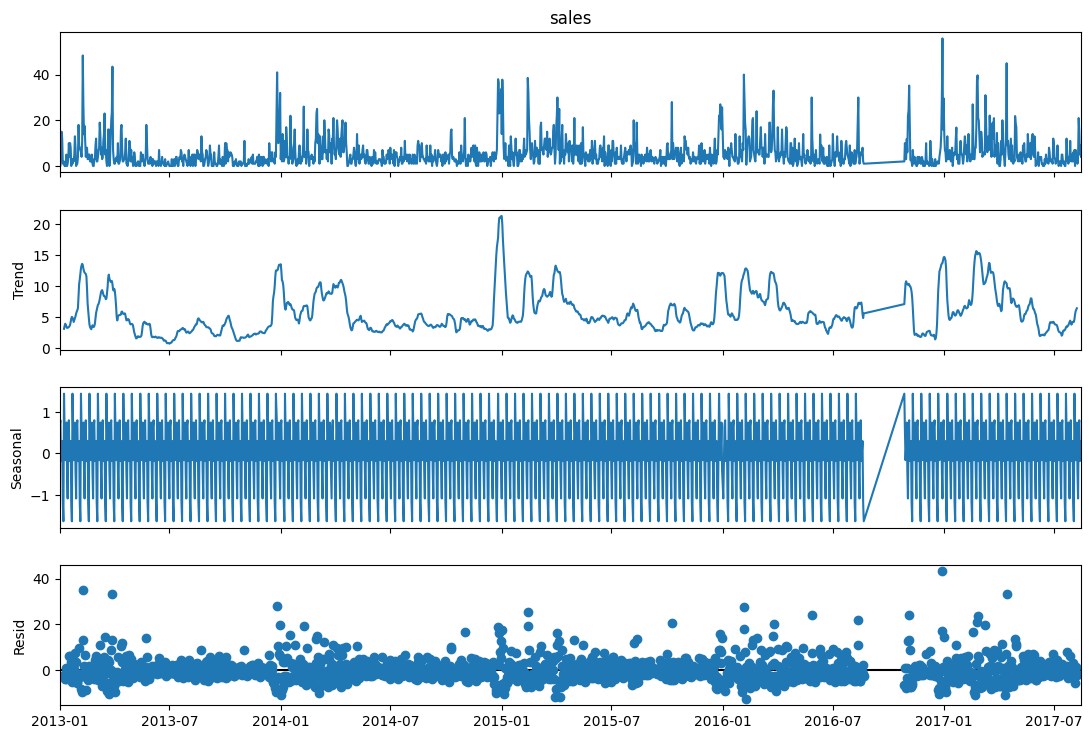

In [15]:
residual = result.resid

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(12, 8)
plt.show()

<Figure size 640x480 with 0 Axes>

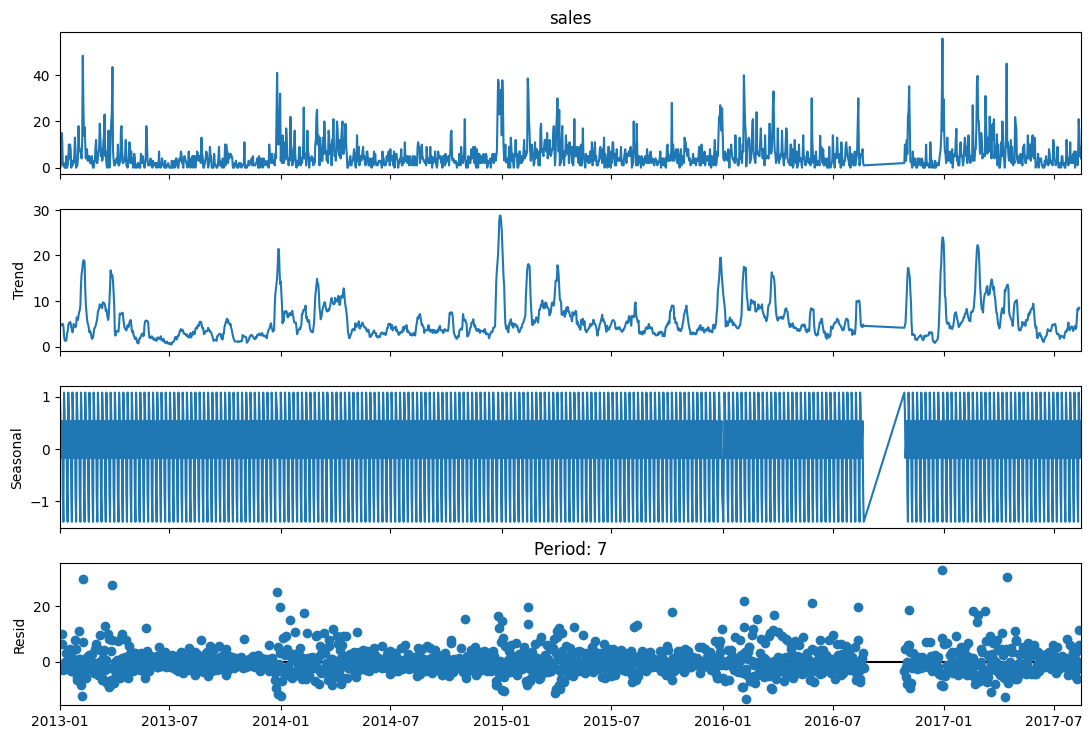

<Figure size 640x480 with 0 Axes>

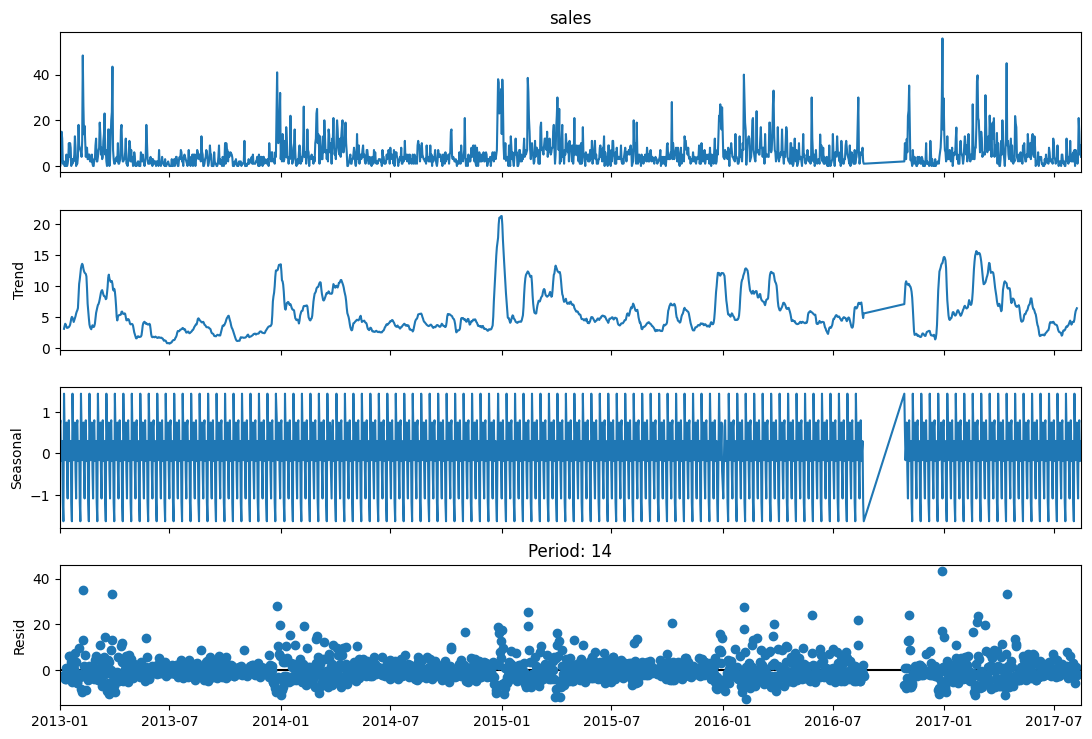

<Figure size 640x480 with 0 Axes>

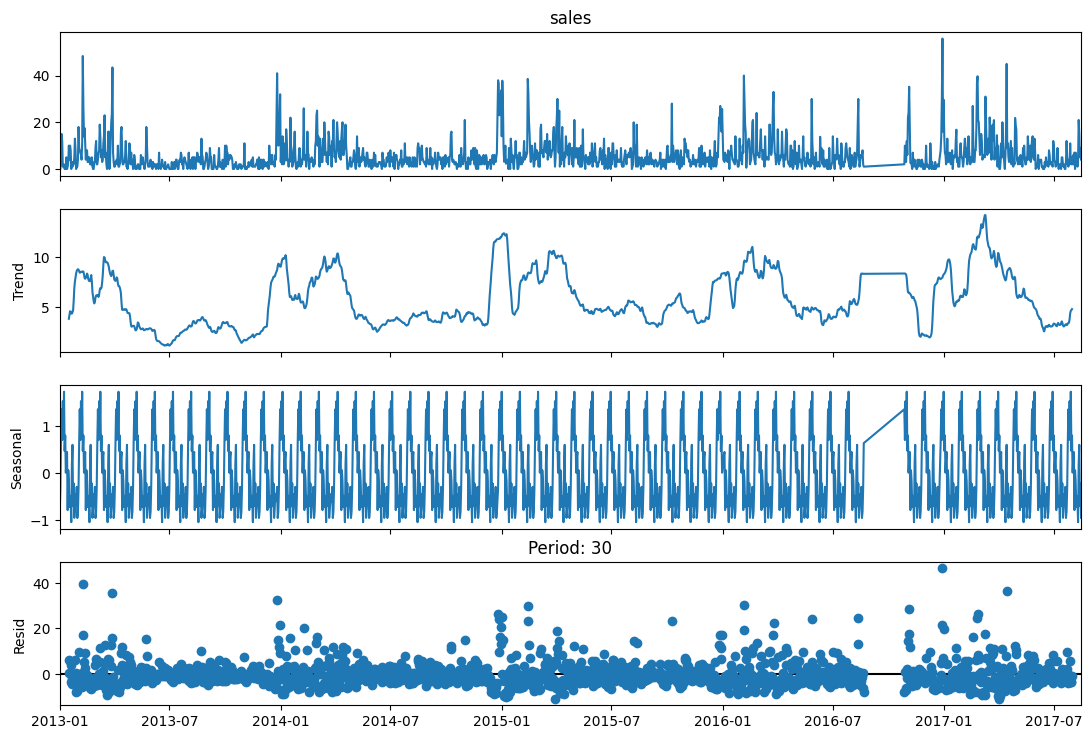

In [16]:
periods = [7, 14, 30]

for period in periods:
    decomposition = seasonal_decompose(example['sales'], period=period, model='additive')
    result = decomposition
    residual = result.resid

    fig = plt.figure()  
    fig = result.plot()  
    fig.set_size_inches(12, 8)
    plt.title(f"Period: {period}")
    plt.show()


In [17]:
example.head(10)

,store_nbr,transactions,id,family,sales
date,,,,,
2013-01-01,25,770,593,SEAFOOD,0.0
2013-01-02,25,1038,2375,SEAFOOD,0.0
2013-01-03,25,887,4157,SEAFOOD,4.0
2013-01-04,25,1054,5939,SEAFOOD,15.0
2013-01-05,25,1355,7721,SEAFOOD,12.0
2013-01-06,25,716,9503,SEAFOOD,1.0
2013-01-07,25,703,11285,SEAFOOD,1.0
2013-01-08,25,626,13067,SEAFOOD,2.0
2013-01-09,25,755,14849,SEAFOOD,0.0


<Axes: xlabel='date'>

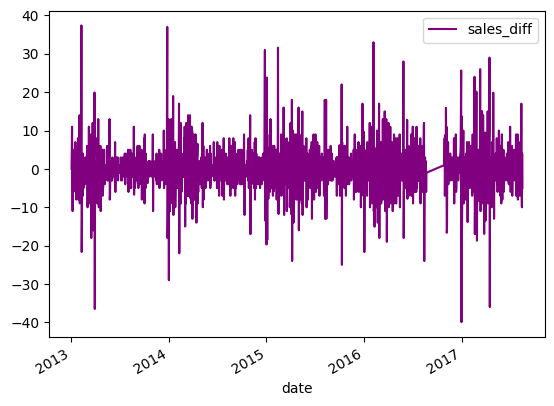

In [18]:
example['sales_diff'] = example['sales'].diff()
example.plot(y='sales_diff', color='purple')


<Axes: xlabel='date'>

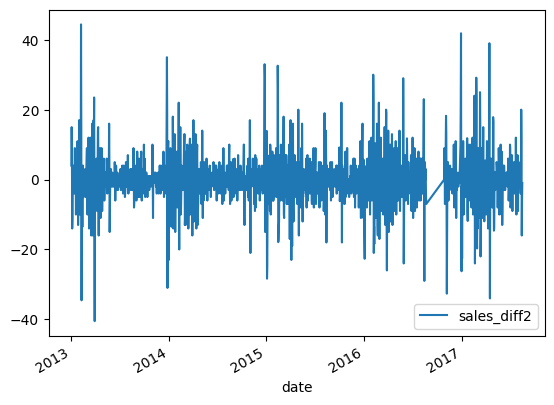

In [19]:
example['sales_diff2'] = example['sales'].diff(2)
example.plot(y='sales_diff2')


<Axes: xlabel='date'>

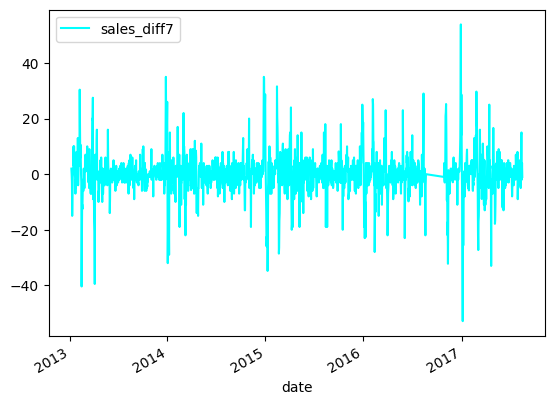

In [20]:
example['sales_diff7'] = example['sales'].diff(7)
example.plot(y='sales_diff7', color='cyan')


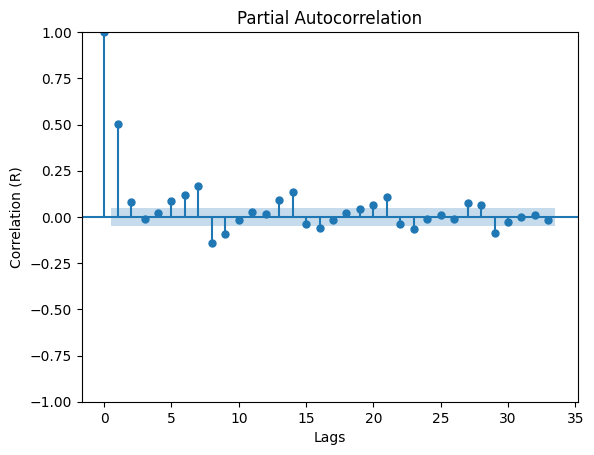

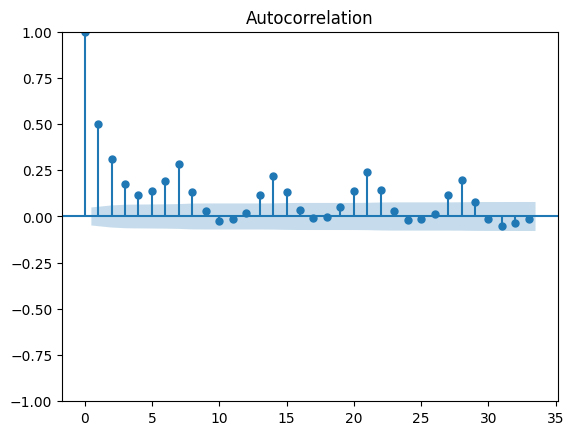

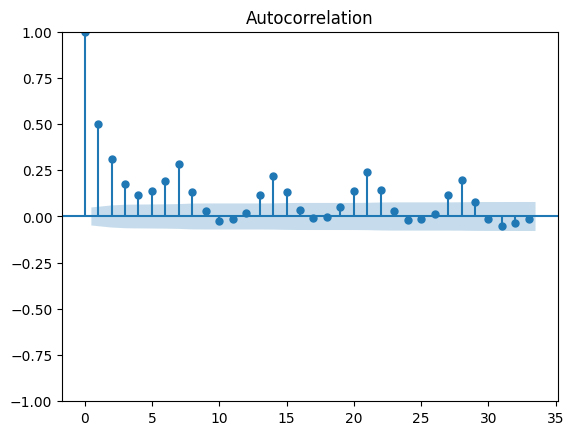

In [46]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plot_pacf(example['sales'])
plt.xlabel('Lags')
plt.ylabel('Correlation (R)')
plt.show()
plot_acf(example['sales'])



In [22]:
example.head(3)

,store_nbr,transactions,id,family,sales,sales_diff,sales_diff2,sales_diff7
date,,,,,,,,
2013-01-01,25,770,593,SEAFOOD,0.0,NaN,NaN,NaN
2013-01-02,25,1038,2375,SEAFOOD,0.0,0.0,NaN,NaN
2013-01-03,25,887,4157,SEAFOOD,4.0,4.0,4.0,NaN


In [23]:
from statsmodels.tsa.stattools import pacf
example_pacf = pacf(example.sales)

In [24]:
example_pacf

array([ 1.00000000e+00,  5.03034834e-01,  7.87146879e-02, -1.20761918e-02,
        1.98332456e-02,  8.84602126e-02,  1.17953482e-01,  1.68183166e-01,
       -1.41037177e-01, -9.04935544e-02, -1.88939887e-02,  2.54553641e-02,
        1.56160184e-02,  9.16019587e-02,  1.33501074e-01, -3.94335079e-02,
       -5.81697897e-02, -1.42252857e-02,  2.02580041e-02,  4.58910807e-02,
        6.61024959e-02,  1.07960074e-01, -4.13276216e-02, -6.80775492e-02,
       -1.37327081e-02,  1.01175721e-02, -8.68350319e-03,  7.74017948e-02,
        6.74753477e-02, -9.16456990e-02, -2.81551997e-02,  3.77348883e-05,
        1.31363713e-02])

### PACF Exploration (D)

In [25]:
import numpy as np
example_pacf = example_pacf[2:]
maximum_value = example_pacf.max()
max_position = np.argmax(example_pacf)
print(max_position)



5


In [26]:
max_pacfs = {}
for key in dfs.keys():
    temp_df = dfs[key]
    temp_pacf = pacf(temp_df.sales)
    temp_pacf = temp_pacf[1:]
    maximum_value = temp_pacf.max()
    max_position = np.argmax(temp_pacf)
    max_pacfs[key] = (maximum_value, max_position)



c:\Users\metal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1489: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)
c:\Users\metal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1489: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)
c:\Users\metal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1489: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)
c:\Users\metal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1489: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)
c:\Users\metal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels

In [27]:
max_pacfs.values()

dict_values([(0.14236592728816203, 13), (0.22616440850858294, 6), (0.300515622018735, 6), (0.11114131028337262, 6), (0.23262768649698093, 6), (0.24262505978862947, 6), (0.09702813002798955, 5), (0.11827564823992602, 13), (0.15255664118600948, 6), (0.11738500584096115, 6), (0.2352552735900532, 0), (0.19259943307026023, 0), (0.22204993210231308, 0), (0.20930268585468437, 0), (0.13197663290139186, 0), (0.24777747310916948, 0), (0.3187737486809253, 0), (0.17070936414708243, 6), (0.28219293263157447, 0), (0.30291187614581827, 0), (0.31492570824815236, 6), (0.2866426972171949, 0), (0.1206441909745471, 6), (0.10200533467156386, 2), (0.28427859271487116, 0), (0.18296320387777726, 0), (0.37239680405968817, 6), (0.2314385046461944, 0), (0.23962000208434076, 0), (0.09105599095867678, 0), (0.3012276665579576, 0), (0.06441532331884235, 6), (0.291713773898073, 0), (0.12645612655839697, 0), (0.20060893877858552, 0), (0.32004534288664094, 0), (0.11184420018187541, 18), (0.28456057354206654, 6), (0.053

(array([1.328e+03, 1.900e+01, 3.000e+00, 3.920e+02, 1.000e+00, 2.000e+00,
        1.000e+00, 3.000e+00, 1.000e+01, 3.000e+00, 2.000e+00, 3.000e+00,
        8.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 0.  ,  1.55,  3.1 ,  4.65,  6.2 ,  7.75,  9.3 , 10.85, 12.4 ,
        13.95, 15.5 , 17.05, 18.6 , 20.15, 21.7 , 23.25, 24.8 , 26.35,
        27.9 , 29.45, 31.  ]),
 <BarContainer object of 20 artists>)

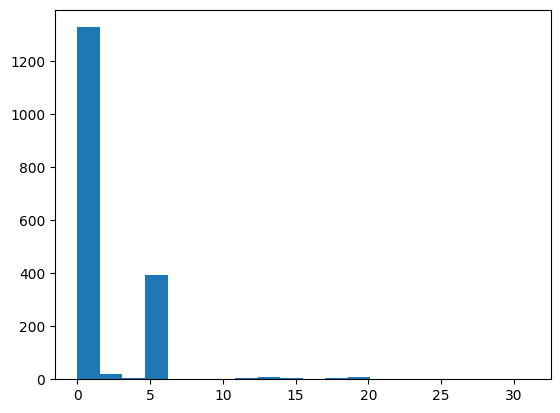

In [28]:
plt.hist([x[1] for x in max_pacfs.values()], bins=20)

# Parameter Hunting


Factors for stationarity:

1. Constant mean and variance,

2. Constant auto correlation

3. Seasonality accounted for


The notation for SARIMA models is SARIMA(p, d, q, P, D, Q, S), where:

p = non-seasonal autoregressive (AR) order

d = non-seasonal differencing

q = non-seasonal moving average (MA) order

P = seasonal AR order (the big P)

D = seasonal differencing

Q = seasonal MA order

S = length of repeating seasonal pattern

### WHERE WE GET P?

we're looking for seasonal spike for big p

In [29]:
from statsmodels.tsa.stattools import acf
max_acfs = {}
for key in dfs.keys():
    temp_df = dfs[key]
    temp_acf = acf(temp_df.sales)
    temp_acf = temp_acf[1:]
    maximum_value = temp_acf.max()
    max_position = np.argmax(temp_acf)
    max_acfs[key] = (maximum_value, max_position)


c:\Users\metal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:691: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


### WHERE WE GET D?


### Q BE HERE

In [30]:
from statsmodels.tsa.stattools import acf
max_acfs = {}
for key in dfs.keys():
    temp_df = dfs[key]
    temp_acf = acf(temp_df.sales)
    temp_acf = temp_acf[1:]
    maximum_value = temp_acf.max()
    max_position = np.argmax(temp_acf)
    max_acfs[key] = (maximum_value, max_position)


In [31]:
family_df.head(3)

,store_nbr,date,transactions,id,family,sales
0,1,2013-01-02,2111,1782,AUTOMOTIVE,2.0
1,1,2013-01-02,2111,1783,BABY CARE,0.0
2,1,2013-01-02,2111,1784,BEAUTY,2.0


In [32]:
family_df.drop(columns=['date', 'transactions', 'sales' ]).value_counts()

store_nbr  id       family             
1          1782     AUTOMOTIVE             1
36         1795455  MEATS                  1
           1795447  HOME AND KITCHEN II    1
           1795448  HOME APPLIANCES        1
           1795449  HOME CARE              1
                                          ..
17         1990771  GROCERY II             1
           1990772  HARDWARE               1
           1990773  HOME AND KITCHEN I     1
           1990774  HOME AND KITCHEN II    1
54         3000755  SEAFOOD                1
Name: count, Length: 2755104, dtype: int64

In [33]:
family_df.drop(columns=['date', 'transactions', 'sales', 'id' ]).drop_duplicates()

,store_nbr,family
0,1,AUTOMOTIVE
1,1,BABY CARE
2,1,BEAUTY
3,1,BEVERAGES
4,1,BOOKS
...,...,...
2699824,54,POULTRY
2699825,54,PREPARED FOODS
2699826,54,PRODUCE
2699827,54,SCHOOL AND OFFICE SUPPLIES


(array([788.,  39.,   9., 706.,   7.,   8.,   3.,   9., 132.,   3.,   4.,
          4.,  14.,   2.,   1.,   1.,   3.,  42.,   5.,   2.]),
 array([ 0.  ,  1.55,  3.1 ,  4.65,  6.2 ,  7.75,  9.3 , 10.85, 12.4 ,
        13.95, 15.5 , 17.05, 18.6 , 20.15, 21.7 , 23.25, 24.8 , 26.35,
        27.9 , 29.45, 31.  ]),
 <BarContainer object of 20 artists>)

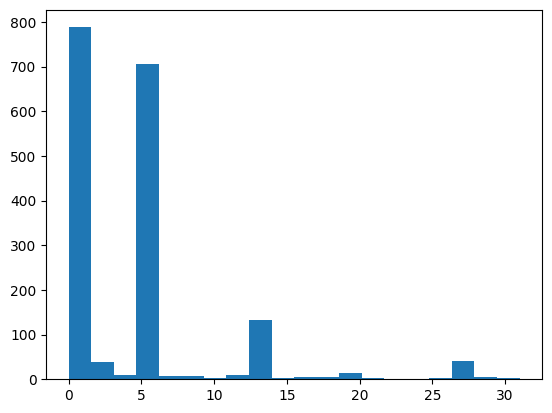

In [34]:
plt.hist([x[1] for x in max_acfs.values()], bins=20)

### p be here

    p being the auto-regressive order

    '''The AR term captures the relationship between an observation and a certain number of lagged observations. The value of "p" determines how many lagged observations are considered in the AR process.''' -Claude Opus


    we can find p by inspecting the ACF graph

    

In [35]:
example.head()

,store_nbr,transactions,id,family,sales,sales_diff,sales_diff2,sales_diff7
date,,,,,,,,
2013-01-01,25,770,593,SEAFOOD,0.0,NaN,NaN,NaN
2013-01-02,25,1038,2375,SEAFOOD,0.0,0.0,NaN,NaN
2013-01-03,25,887,4157,SEAFOOD,4.0,4.0,4.0,NaN
2013-01-04,25,1054,5939,SEAFOOD,15.0,11.0,15.0,NaN
2013-01-05,25,1355,7721,SEAFOOD,12.0,-3.0,8.0,NaN


In [36]:
import numpy as np
p_fall_off_points = {}
for key in dfs.keys():
    temp_df = dfs[key]
    temp_pacf = pacf(temp_df.sales)

    


    threshold = 0.05
    bool_mask = np.abs(temp_pacf) < threshold
    first_value = temp_pacf[bool_mask][0]
    index = np.where(temp_pacf == first_value)[0][0]
    
    #We add one to the index to get the actual lag. Hurray!
    p_fall_off_points[key] = (first_value, index+1)



c:\Users\metal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1489: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)
c:\Users\metal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1489: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)
c:\Users\metal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1489: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)
c:\Users\metal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1489: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)
c:\Users\metal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels

In [37]:
from statsmodels.tsa.stattools import pacf
pacf_values = pacf(dfs[('AUTOMOTIVE', 1)].sales)
print(pacf_values)


[ 1.          0.10230241  0.03768068  0.08757749  0.06748364  0.06105627
  0.05794871  0.13427499  0.02014581  0.06011746  0.07573654  0.08098039
 -0.01173697  0.05799419  0.14236593  0.04521058  0.02006933  0.03212501
  0.04798764 -0.0040949   0.02214845  0.12184973 -0.02209699 -0.02661536
  0.0480841   0.01563194 -0.01402148  0.07005425  0.07928091  0.0190153
 -0.00761427  0.02926202 -0.00650096]


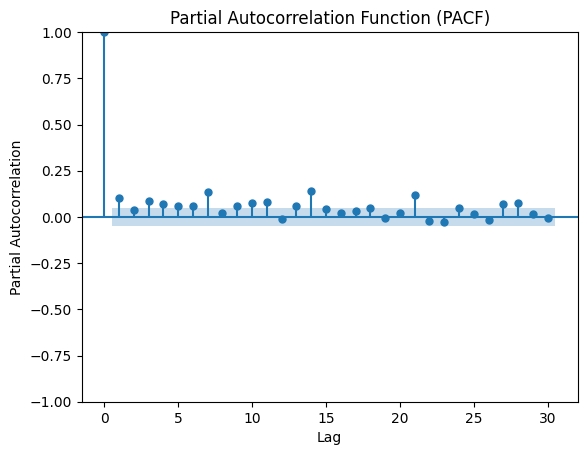

In [38]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(dfs['AUTOMOTIVE', 1].sales, lags=30)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


In [39]:
#This dictionary represtents the little p for all of our time serieses
for key in p_fall_off_points.keys():
    print(key, p_fall_off_points[key])

('AUTOMOTIVE', 1) (0.037680683028420835, 3)
('AUTOMOTIVE', 2) (0.004019739544076782, 3)
('AUTOMOTIVE', 3) (0.022493315986203105, 3)
('AUTOMOTIVE', 4) (-0.04369809181543742, 3)
('AUTOMOTIVE', 5) (0.0207452677105707, 3)
('AUTOMOTIVE', 6) (-0.015341402709254033, 3)
('AUTOMOTIVE', 7) (0.03708262378400158, 2)
('AUTOMOTIVE', 8) (-0.016557048963228543, 3)
('AUTOMOTIVE', 9) (0.047873589992700645, 3)
('AUTOMOTIVE', 10) (0.04849361841646004, 3)
('AUTOMOTIVE', 11) (0.03768494181024372, 6)
('AUTOMOTIVE', 12) (0.03932012585187783, 3)
('AUTOMOTIVE', 13) (0.018773403799054712, 9)
('AUTOMOTIVE', 14) (-0.0021349851797916844, 10)
('AUTOMOTIVE', 15) (0.005625925115351072, 4)
('AUTOMOTIVE', 16) (0.04006913344758236, 9)
('AUTOMOTIVE', 17) (-0.02637369681549734, 10)
('AUTOMOTIVE', 18) (0.03947681313136745, 3)
('AUTOMOTIVE', 19) (0.02517448562309068, 5)
('AUTOMOTIVE', 20) (-0.016144898749168593, 3)
('AUTOMOTIVE', 21) (-0.009080485330440665, 4)
('AUTOMOTIVE', 22) (0.007917223424671617, 4)
('AUTOMOTIVE', 23) (

### d is here

this depends on the stationarity of our data.

the adf is testing for stationarity with respect to trend

In [40]:
from statsmodels.tsa.stattools import adfuller

# Extract the sales data from the example DataFrame
sales_data = example['sales']

# Run the augmented Dickey-Fuller test
result = adfuller(sales_data)

# Print the test statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])



ADF Statistic: -6.168495817806978
p-value: 6.896367841277032e-08


In [41]:
print(type(sales_data))
print(sales_data)

<class 'pandas.core.series.Series'>
date
2013-01-01     0.0
2013-01-02     0.0
2013-01-03     4.0
2013-01-04    15.0
2013-01-05    12.0
              ... 
2017-08-11    21.0
2017-08-12    15.0
2017-08-13     5.0
2017-08-14     9.0
2017-08-15     4.0
Name: sales, Length: 1615, dtype: float64


With the above conclusion from the ADF we can reject the null hypothesis of our data not being stationary. This means we do not need to difference our data and our little d can be 0 for this example data set. We still need to test the whole collection of dataframes

In [42]:
import numpy as np
adfuller_booleans = {}
for key in dfs.keys():
    temp_df = dfs[key]

    try:
        result = adfuller(temp_df.sales)
        threshold = 0.05
        hypothesis_boolean = result[1] < threshold
        adfuller_booleans[key] = (hypothesis_boolean)
    except:
        print("hyuck")
        adfuller_booleans[key] = 'dyuck'
        continue

    


   
    
    #We add one to the index to get the actual lag. Hurray!
    



hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck
hyuck


In [ ]:
for key in adfuller_booleans.keys():
    print(key, adfuller_booleans[key])

('AUTOMOTIVE', 1) True
('AUTOMOTIVE', 2) True
('AUTOMOTIVE', 3) True
('AUTOMOTIVE', 4) True
('AUTOMOTIVE', 5) True
('AUTOMOTIVE', 6) True
('AUTOMOTIVE', 7) True
('AUTOMOTIVE', 8) True
('AUTOMOTIVE', 9) True
('AUTOMOTIVE', 10) True
('AUTOMOTIVE', 11) True
('AUTOMOTIVE', 12) True
('AUTOMOTIVE', 13) True
('AUTOMOTIVE', 14) True
('AUTOMOTIVE', 15) True
('AUTOMOTIVE', 16) True
('AUTOMOTIVE', 17) True
('AUTOMOTIVE', 18) True
('AUTOMOTIVE', 19) True
('AUTOMOTIVE', 20) True
('AUTOMOTIVE', 21) True
('AUTOMOTIVE', 22) True
('AUTOMOTIVE', 23) True
('AUTOMOTIVE', 24) True
('AUTOMOTIVE', 25) True
('AUTOMOTIVE', 26) True
('AUTOMOTIVE', 27) False
('AUTOMOTIVE', 28) True
('AUTOMOTIVE', 29) True
('AUTOMOTIVE', 30) True
('AUTOMOTIVE', 31) True
('AUTOMOTIVE', 32) True
('AUTOMOTIVE', 33) True
('AUTOMOTIVE', 34) True
('AUTOMOTIVE', 35) True
('AUTOMOTIVE', 36) True
('AUTOMOTIVE', 37) True
('AUTOMOTIVE', 38) True
('AUTOMOTIVE', 39) True
('AUTOMOTIVE', 40) True
('AUTOMOTIVE', 41) True
('AUTOMOTIVE', 42) True


In [ ]:
true_count = 0
false_count = 0
duck_count = 0

for key in adfuller_booleans.keys():
    if adfuller_booleans[key] == True:
        true_count += 1
    elif adfuller_booleans[key] == 'dyuck':
        duck_count +=1
    else:
        false_count += 1

print(true_count, false_count, duck_count)




1357 372 53


From the above we can conclude that 53 stores/family combinations never made any sales, presumably due to not carrying that product.
We can also conclude that 1357 of our data sets are already stationary. WOO!
Then that leaves us with the open question of what kind of differencing do our 372 remaining stores require?!


### where we get q?